In [361]:
import numpy as np
import numpy.random as rand
import numpy.linalg as linalg
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import tensorflow as tf

# SNR is a range between min and max SNR in dB
def generate_signal(N = 16, K = 4, L = 16, f = 2.4e9, theta_bound = np.pi/2):
    c = 3e8 # speed of light
    wl = c/f # wavelength (lambda)
    d = wl/2 # uniform distance between antennas
        
    # antenna array
    array = np.linspace(0,N-1,N)*d/wl

    theta = rand.rand(K,1) * np.pi - np.pi/2

    
    alpha = (np.random.randn(K,1) + 1j*np.random.randn(K,1))*np.sqrt(1/2)
        
    response = np.exp(-1j*2*np.pi*array*np.sin(theta))*np.sqrt(1/N)    

    Y = np.dot(response.T, alpha).repeat(L, axis=1)

                
    return theta, Y, alpha

K = 4
T = 2
D = 180
N = 64

samples = 10000

rads_to_vector = lambda x: np.floor((x + np.pi/2)/np.pi * D).astype(int)


N_list = N #[16, 32, 48, 64, 96]

SNR_list = [5,10,15,20,25,30]

N_max = np.max(N_list)

Y = np.zeros((samples, N_max, T), dtype=np.complex64)
Theta = np.zeros((samples, K))
Alpha = np.zeros((samples, K), dtype=np.complex64)

labels = np.zeros((samples, D, T), dtype=np.complex64)

for i in range(samples):
    theta, Yi, alpha = generate_signal(N_max, K, T)
    Y[i] = Yi
    Theta[i] = theta.flatten()
    
    idx = rads_to_vector(theta)
    labels[i, idx, :] = np.repeat(alpha, repeats=T, axis=0).reshape((K,1,T))

#Y = Y.reshape((samplesT, N_max))
#labels = labels.reshape((samples, D, T))
    
labels = np.concatenate([labels.real, labels.imag], axis=1)
#labels = labels.transpose((0,2,1)) #/ np.max(np.abs(labels))
data = Y #/ np.max(np.abs(Y))

#data = np.concatenate([data.real, data.imag], axis=2)

print(labels.shape)
print(data.shape)

(10000, 360, 2)
(10000, 64, 2)


In [364]:
import numpy as np
import numpy.random as rand
import numpy.linalg as linalg
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import initializers

def compute_H(theta, N, f = 2.4e9):
    c = 3e8 # speed of light
    wl = c/f # wavelength (lambda)
    d = wl/2 # uniform distance between antennas
    array = np.linspace(0,N-1,N)*d/wl
    
    array_response = np.exp(-1j*2*np.pi*array*np.sin(theta))*np.sqrt(1/N)  
    return array_response.T

def soft_thresh(Z, l):
    return tf.math.sign(Z) * tf.maximum(tf.abs(Z) - l, 0.)

def soft_block_thresh(Z, l, alpha, T):
    rmse = tf.norm(Z, axis=2)
    #print(rmse.shape)
    rmse = tf.tile(tf.expand_dims(rmse, axis=2), multiples=[1,1,T])
    #print(rmse.shape)
    return (1 - l/tf.maximum(rmse, l))*Z # / (1+alpha)

mul_X = lambda w, x: tf.transpose(tf.tensordot(w, x, axes=[[1],[1]]), [1,0,2])
mul_Y = lambda w, y: tf.transpose(tf.tensordot(w, y, axes=[[1],[1]]), [1,0,2])

transform_X = lambda x: tf.transpose(tf.expand_dims(x, 2), [0,3,1,2])
transform_hgX = lambda x: tf.squeeze(tf.transpose(x, [0,2,1,3]), axis=3)
conv_X = lambda hg, x: transform_hgX(hg(transform_X(x)))



search_space = np.linspace(0,D-1, D) / D * np.pi - np.pi/2
search_space = search_space.reshape((D, 1))

H = compute_H(search_space, N)

L = np.linalg.norm(H)**2
lam_initial = 4e-3

step_size = 0.5/L

We_initial = 2 * step_size * H.T.conj()
Wt_initial = np.eye(D) - H.T.conj().dot(H) * step_size

class LISTA(tf.keras.Model):  #@save
    def __init__(self, num_iter, D, N, T):
        super(LISTA, self).__init__()
        self.num_iter = num_iter
        self.T = T
        self.N = N
        self.D = D
        
        self.Wt_r = tf.Variable(Wt_initial.real.copy(), dtype=tf.float32)
        self.Wt_i = tf.Variable(Wt_initial.imag.copy(), dtype=tf.float32)
        
        self.We_r = tf.Variable(We_initial.real.copy(), dtype=tf.float32)
        self.We_i = tf.Variable(We_initial.imag.copy(), dtype=tf.float32)
        
        self.lam_list = []
        
        for i in range(num_iter):
            self.lam_list.append(tf.Variable(lam_initial, dtype=tf.float32))
    
        self.alpha = tf.Variable(0.1, dtype=tf.float32)

    def call(self, Y):
        
        Y_r = tf.math.real(Y)
        Y_i = tf.math.imag(Y)
        
        X_r = mul_Y(self.We_r, Y_r)
        X_r = soft_block_thresh(X_r, self.lam_list[0], self.alpha, self.T)
        X_i = mul_Y(self.We_i, Y_i)
        X_i = soft_block_thresh(X_i, self.lam_list[0], self.alpha, self.T)

        for i in range(1, self.num_iter):
            X_r = mul_X(self.Wt_r, X_r) - mul_X(self.Wt_i, X_i) + mul_Y(self.We_r, Y_r) - mul_Y(self.We_i, Y_i)
            #print(X_r.shape)
            
            X_r = soft_block_thresh(X_r, self.lam_list[i], self.alpha, self.T)
            X_i = mul_X(self.Wt_r, X_i) + mul_X(self.Wt_i, X_r) + mul_Y(self.We_r, Y_i) + mul_Y(self.We_i, Y_r)
            X_i = soft_block_thresh(X_i, self.lam_list[i], self.alpha, self.T)
            
        X = tf.concat([X_r, X_i], axis=1)
        
        return X #self.bn(X)

class LISTA_Toeplitz(tf.keras.Model):  #@save
    def __init__(self, num_iter, D, N, T):
        super(LISTA_Toeplitz, self).__init__()
        self.num_iter = num_iter
        self.T = T
        self.N = N
        self.D = D
        
        self.hg_r_ = tf.keras.layers.Conv1D(1, 2*D-1, activation='linear', padding='same')
        self.hg_i_ = tf.keras.layers.Conv1D(1, 2*D-1, activation='linear', padding='same')
        
        self.hg_r = tf.keras.layers.TimeDistributed(self.hg_r_)
        self.hg_i = tf.keras.layers.TimeDistributed(self.hg_i_)
        
        self.We_r = tf.Variable(We_initial.real.copy(), dtype=tf.float32)
        self.We_i = tf.Variable(We_initial.imag.copy(), dtype=tf.float32)
        
        self.lam_list = []
        
        for i in range(num_iter):
            self.lam_list.append(tf.Variable(lam_initial, dtype=tf.float32))
    
        self.alpha = tf.Variable(0.1, dtype=tf.float32)

    def call(self, Y):
        
        Y_r = tf.math.real(Y)
        Y_i = tf.math.imag(Y)

        X_r = mul_Y(self.We_r, Y_r)
        X_r = soft_block_thresh(X_r, self.lam_list[0], self.alpha, self.T)
        X_i = mul_Y(self.We_i, Y_i)
        X_i = soft_block_thresh(X_i, self.lam_list[0], self.alpha, self.T)
        

        for i in range(1, self.num_iter):
            X_r = conv_X(self.hg_r, X_r) - conv_X(self.hg_i, X_i) + mul_Y(self.We_r, Y_r) - mul_Y(self.We_i, Y_i)
            X_r = soft_block_thresh(X_r, self.lam_list[i], self.alpha, self.T)
            X_i = conv_X(self.hg_r, X_i) + conv_X(self.hg_i, X_r) + mul_Y(self.We_r, Y_i) + mul_Y(self.We_i, Y_r)
            X_i = soft_block_thresh(X_i, self.lam_list[i], self.alpha, self.T)
        
        X = tf.concat([X_r, X_i], axis=1)
        
        return X

In [365]:
lista_model = LISTA_Toeplitz(3, D, N, T)

learning_rate = 0.001

adaptive_learning_rate = lambda epoch: learning_rate/(2**np.floor(epoch/10))

adam = tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, min_delta=1e-5)
lrate = tf.keras.callbacks.LearningRateScheduler(adaptive_learning_rate)

lista_model.compile(optimizer=adam, loss='mse')

m = lista_model.fit(data, labels, batch_size=32, epochs=20, validation_split=0.1, callbacks=[stopping, lrate])

Epoch 1/20
282/282 [==============================] - 74s 252ms/step - loss: 0.0091 - val_loss: 0.0072
Epoch 2/20
282/282 [==============================] - 70s 249ms/step - loss: 0.0071 - val_loss: 0.0070
Epoch 3/20
282/282 [==============================] - 75s 268ms/step - loss: 0.0069 - val_loss: 0.0070
Epoch 4/20
 33/282 [==>...........................] - ETA: 57s - loss: 0.0067

KeyboardInterrupt: 

(None, 1, 180)
(1, 180, 1)
(1, 1, 360)


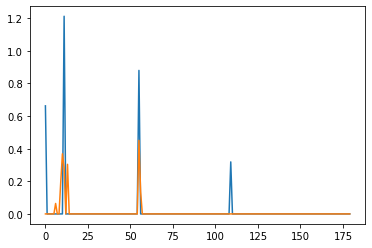

In [130]:
SNR_list = [5,10,15,20,25,30]

tsamples = 1

N_max = np.max(N_list)

Y = np.zeros((tsamples, T, N_max), dtype=np.complex64)
Theta = np.zeros((tsamples, K))
Alpha = np.zeros((tsamples, K), dtype=np.complex64)

labels = np.zeros((tsamples, D, T), dtype=np.complex64)

for i in range(tsamples):
    theta, Yi, alpha = generate_signal(N_max, K, T)
    Y[i] = Yi.T
    Theta[i] = theta.flatten()
    
    idx = rads_to_vector(theta)
    labels[i, idx, :] = np.repeat(alpha, repeats=T, axis=0).reshape((K,1,T))

#Y = Y.reshape((samplesT, N_max))
labels = labels.reshape((tsamples, D, T))
data = Y
#data = np.concatenate([data.real, data.imag], axis=2)

pred = lista_model.predict(data)

pred_r, pred_i = np.array_split(pred, 2, axis=2)

pred = pred_r + 1j*pred_i

print(labels.shape)
print(lista_model.predict(data).shape)

plt.figure(0)
plt.plot(np.abs(labels.mean(axis=2)).flatten())
plt.plot(np.abs(pred.mean(axis=1)).flatten())




#lista_model.evaluate(data_test, labels_test)#/tf.linalg.norm(labels_test)**2

In [ ]:
import tensorflow as tf
import numpy as np



l = tf.Variable(0.5, dtype=tf.float32)

def soft_block_thresh(Z, l, T):
    rmse = tf.norm(Z, axis=2)
    rmse = tf.repeat(tf.expand_dims(rmse, axis=2), repeats=T, axis=2)
    return tf.maximum(0., 1 - l/rmse)*Z

Z = tf.Variable(np.random.randn(10, 180, 2), dtype=tf.float32) * 0.3

soft_block_thresh(Z, l, 2)

#res
#type(thresh)
#thresh(Z)

In [367]:
def soft_block_thresh(Z, l, alpha, T):
    rmse = tf.norm(Z, axis=2)
    rmse = tf.expand_dims(rmse, axis=-1)
    #print(rmse.shape)
    rmse = tf.tile(rmse, multiples=[1, 1, T])
    #print(rmse.shape)
    return (1 - l/tf.maximum(rmse, l))*Z

Y = np.random.randn(4,64,2)
X = np.random.randn(4,2,180)
We = np.random.randn(180,64)
Wt = np.random.randn(180,180)

X_ = tf.transpose(tf.expand_dims(X_, 2), [0,3,1,2])



conv = tf.keras.layers.Conv1D(2, 2*180-1, activation='linear', padding='same')

#td = tf.keras.layers.TimeDistributed(conv)

#X = tf.transpose(tf.expand_dims(X, 2), [0,3,1,2])

#X = tf.squeeze(tf.transpose(td(X), [0,2,1,3]), axis=3)

#X_ = tf.squeeze(tf.transpose(td(X_), [0,2,1,3]), axis=3)

print(conv(X))

tf.Tensor(
[[[ 0.00835543  0.19059657]
  [ 0.17543498 -0.15336744]]

 [[ 0.08993522  0.10263053]
  [-0.03773974  0.02691964]]

 [[-0.16501227  0.23341803]
  [ 0.2254911  -0.18468982]]

 [[-0.17568406 -0.0419488 ]
  [-0.01121866 -0.18006928]]], shape=(4, 2, 2), dtype=float32)


In [354]:
X_.shape

TensorShape([180])